# Model -> https://huggingface.co/poom-sci/WangchanBERTa-finetuned-sentiment

# Install Dependencies

In [ ]:
!pip install -q transformers transformers[sentencepiece] datasets

     |████████████████████████████████| 3.1 MB 7.9 MB/s 
     |████████████████████████████████| 290 kB 70.2 MB/s 
     |████████████████████████████████| 895 kB 53.3 MB/s 
     |████████████████████████████████| 59 kB 9.2 MB/s 
     |████████████████████████████████| 596 kB 71.9 MB/s 
     |████████████████████████████████| 3.3 MB 66.0 MB/s 
     |████████████████████████████████| 243 kB 77.4 MB/s 
     |████████████████████████████████| 132 kB 77.0 MB/s 
     |████████████████████████████████| 1.1 MB 56.5 MB/s 
     |████████████████████████████████| 160 kB 72.0 MB/s 
     |████████████████████████████████| 271 kB 63.8 MB/s 
     |████████████████████████████████| 192 kB 77.3 MB/s 
     |████████████████████████████████| 1.2 MB 54.9 MB/s 


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!nvidia-smi

Tue Nov  9 16:33:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# To control logging level for various modules used in the application:
import logging
import re
def set_global_logging_level(level=logging.ERROR, prefices=[""]):
    """
    Override logging levels of different modules based on their name as a prefix.
    It needs to be invoked after the modules have been loaded so that their loggers have been initialized.

    Args:
        - level: desired level. e.g. logging.INFO. Optional. Default is logging.ERROR
        - prefices: list of one or more str prefices to match (e.g. ["transformers", "torch"]). Optional.
          Default is `[""]` to match all active loggers.
          The match is a case-sensitive `module_name.startswith(prefix)`
    """
    prefix_re = re.compile(fr'^(?:{ "|".join(prefices) })')
    for name in logging.root.manager.loggerDict:
        if re.match(prefix_re, name):
            logging.getLogger(name).setLevel(level)

set_global_logging_level(logging.ERROR, ["transformers", "nlp", "torch", "tensorflow", "tensorboard", "wandb"])

# Import Dependencies

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

from datasets import (concatenate_datasets,
                    Dataset,
                    load_dataset,
                    load_metric)

from transformers import (AutoTokenizer, 
                        DataCollatorWithPadding,
                        AutoModelForSequenceClassification,
                        EarlyStoppingCallback,
                        AdamW,
                        get_cosine_schedule_with_warmup,
                        pipeline,
                        AutoModelForSequenceClassification,
                        Trainer,
                        TrainingArguments)

from torch.optim.lr_scheduler import StepLR
from transformers.optimization import Adafactor, AdafactorSchedule
from sklearn.metrics import confusion_matrix,classification_report

# Declaration

In [ ]:

dataset_path='gdrive/MyDrive/nvidia/huggingface/dataset'
dataset_name='/wongnai-wisesight'

model_path='gdrive/MyDrive/nvidia/huggingface/AWS_REVIEW/wangchanberta_th_ws_lr-linear'
model_name='/wangchanberta_th_ws_lr'

checkpoint = "airesearch/wangchanberta-base-att-spm-uncased"

test_model=model_path+model_name


# Data Preparation

## load new DATASET

In [ ]:
# ----------------------------LOAD DATASET-------------------------

df=pd.read_csv('/content/combined_csv (4).csv',lineterminator='\n')
df=df.rename(columns={'class':'labels','text':'texts'})

def convert_labels(example):
    if example['labels']==0:
        example['labels'] = 2
    elif example['labels']==1:
        example['labels'] = 0
    return example

own_dataset = Dataset.from_pandas(df)
own_dataset = own_dataset.map(convert_labels)



def convert_stars_to_sentimental(example):
    if example['labels']<2:
        example['labels'] = 2
    elif example['labels']==2:
        example['labels'] = 1
    else:
        example['labels'] = 0
    return example

wongnai_datasets = load_dataset("wongnai_reviews")
wongnai_datasets = wongnai_datasets.rename_column("star_rating", "labels")
wongnai_datasets = wongnai_datasets.rename_column("review_body", "texts")
wongnai_datasets = wongnai_datasets.map(convert_stars_to_sentimental)
wongnai_datasets['train']=concatenate_datasets([wongnai_datasets['train'],wongnai_datasets['test'].filter(lambda x,indices: indices<=2000,with_indices=True )])
wongnai_datasets['validation']=wongnai_datasets['test'].filter(lambda x,indices: 2000<indices<=4000 ,with_indices=True )
wongnai_datasets['test']=wongnai_datasets['test'].filter(lambda x,indices: indices>4000,with_indices=True )


wisesight_dataset = load_dataset("wisesight_sentiment")
wisesight_dataset = wisesight_dataset.filter(lambda example: example['category']!=3)
wisesight_dataset = wisesight_dataset.rename_column("category", "labels")

def convert_generated_reviews(example):
    example['translation']=example['translation']['th']
    if example['review_star']==3:
        example['review_star']=1
    elif example['review_star']<3:
        example['review_star']=2
    elif example['review_star']>3:
        example['review_star']=0
    return example

generated_reviews_enth = load_dataset("generated_reviews_enth").filter(lambda x,indices: x['correct']=='pos' ,with_indices=True)
generated_reviews_enth = load_dataset("generated_reviews_enth").filter(lambda x,indices: 0<x['review_star']<6,with_indices=True)
generated_reviews_enth = generated_reviews_enth.map(convert_generated_reviews)
generated_reviews_enth=generated_reviews_enth.rename_column('review_star','labels')
generated_reviews_enth=generated_reviews_enth.rename_column('translation','texts')
generated_reviews_enth=generated_reviews_enth.remove_columns(['correct'])

# # ----------------------------CAST DATA FEATURE-------------------------

own_dataset=own_dataset.cast(wisesight_dataset['test'].features)
generated_reviews_enth=generated_reviews_enth.cast(wongnai_datasets['test'].features)

# # ----------------------------CONCAT TRAIN-------------------------

th_sentimental_corpus=wisesight_dataset

th_sentimental_corpus['train']= concatenate_datasets([own_dataset,wisesight_dataset['train']]).shuffle(seed=42)
th_sentimental_corpus['validation']=concatenate_datasets([wisesight_dataset['validation']])
th_sentimental_corpus['test']=concatenate_datasets([wisesight_dataset['test']])

th_sentimental_corpus.save_to_disk(dataset_path+dataset_name)

  0%|          | 0/1048 [00:00<?, ?ex/s]

Reusing dataset wisesight_sentiment (/root/.cache/huggingface/datasets/wisesight_sentiment/wisesight_sentiment/1.0.0/fc2b1bdfe79571b2e281e4afdb5aac069cf9270bf0f85694239be672a4191969)


  0%|          | 0/3 [00:00<?, ?it/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/wisesight_sentiment/wisesight_sentiment/1.0.0/fc2b1bdfe79571b2e281e4afdb5aac069cf9270bf0f85694239be672a4191969/cache-212cfe55ce96de07.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wisesight_sentiment/wisesight_sentiment/1.0.0/fc2b1bdfe79571b2e281e4afdb5aac069cf9270bf0f85694239be672a4191969/cache-b65b6cd582aa76cf.arrow


## load from local

In [ ]:
# wisesight_dataset = load_dataset("wisesight_sentiment")
# wisesight_dataset = wisesight_dataset.filter(lambda example: example['category']!=3)
# wisesight_dataset = wisesight_dataset.rename_column("category", "labels")
# th_sentimental_corpus=wisesight_dataset
# th_sentimental_corpus = th_sentimental_corpus.load_from_disk(dataset_path+dataset_name)

## Dataset Structure

In [ ]:
th_sentimental_corpus

DatasetDict({
    train: Dataset({
        features: ['texts', 'labels'],
        num_rows: 22676
    })
    validation: Dataset({
        features: ['texts', 'labels'],
        num_rows: 2404
    })
    test: Dataset({
        features: ['texts', 'labels'],
        num_rows: 2671
    })
})

## Tokenize Text

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["texts"],max_length=510,truncation=True)

tokenized_datasets = th_sentimental_corpus.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Loading cached processed dataset at /root/.cache/huggingface/datasets/wisesight_sentiment/wisesight_sentiment/1.0.0/fc2b1bdfe79571b2e281e4afdb5aac069cf9270bf0f85694239be672a4191969/cache-abe4348309306129.arrow


  0%|          | 0/3 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/wisesight_sentiment/wisesight_sentiment/1.0.0/fc2b1bdfe79571b2e281e4afdb5aac069cf9270bf0f85694239be672a4191969/cache-5238b872e25bb268.arrow


In [ ]:
# tokenized_datasets=tokenized_datasets.remove_columns(['texts'])

# Training Model

## Set Training Argument

In [ ]:
training_args=TrainingArguments(
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    save_steps=200,
    overwrite_output_dir=True,
    output_dir=model_path,
    logging_dir=model_path+'/logs',
    load_best_model_at_end =True,
    evaluation_strategy ='steps',
    eval_steps = 200,
    metric_for_best_model ='eval_loss',
    greater_is_better=False,
    logging_steps=200,
    warmup_steps=400,
    remove_unused_columns=True,
    hub_model_id ='poom-sci/WangchanBERTa-finetuned-sentiment',
    # dataloader_num_workers=0
    # hub_token ='OZGWlaSJuzSEImyTFrJYpERzXPXEWzdvSSETiUrUhvwIxzKdKpldtLLTEUKAeuXSDigMRjaizmwKPOxALNdkMUVotAAOIDOQodCQOAvcGtQktukwcPkSbxiZCroAjeHV',
    # push_to_hub=True
    # report_to =None,
    # lr_scheduler_type='polynomial'
)

## model setup with optimizer and lr_scheduler

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=4,ignore_mismatched_sizes=True)
model.config.hidden_dropout_prob=0.2
model.config.classifier_dropout=0.2
# print(model.config)
# optimizer = AdamW(model.parameters(), 
#                   lr = training_args.learning_rate, 
#                   weight_decay=training_args.weight_decay)

# lr_scheduler = get_cosine_schedule_with_warmup(optimizer,
#                                                num_warmup_steps=training_args.warmup_steps,
#                                                num_training_steps=round(len(tokenized_datasets['train'])/training_args.per_device_train_batch_size)* training_args.num_train_epochs )

# optimizer = Adafactor(model.parameters(),
#                       relative_step=True, 
#                       warmup_init=True, 
#                       lr=None,
#                       scale_parameter =True,
#                       weight_decay=training_args.weight_decay)

# lr_scheduler = AdafactorSchedule(optimizer,
#                                  initial_lr=training_args.learning_rate)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    # callbacks = [EarlyStoppingCallback(early_stopping_patience = 4)],
    # optimizers=(optimizer,lr_scheduler)
    # compute_metrics=compute_metrics
)

model.config.label2id={'pos':0,'neu':1,'neg':2}
model.config.id2label={0:'pos',1:'neu',2:'neg'}

Some weights of the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at airesearch/wa

## Start Training

In [ ]:
trainer.train(resume_from_checkpoint=False)

The following columns in the training set  don't have a corresponding argument in `CamembertForSequenceClassification.forward` and have been ignored: texts.
***** Running training *****
  Num examples = 22676
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 5672


Step,Training Loss,Validation Loss
200,1.189000,1.018608
400,0.956000,0.856169
600,0.815900,0.787246
800,0.705100,0.707190
1000,0.705600,0.743538
1200,0.728900,0.729818
1400,0.701400,0.719107
1600,0.649800,0.671076
1800,0.608100,0.647969
2000,0.593000,0.638952


The following columns in the evaluation set  don't have a corresponding argument in `CamembertForSequenceClassification.forward` and have been ignored: texts.
***** Running Evaluation *****
  Num examples = 2404
  Batch size = 16
Saving model checkpoint to gdrive/MyDrive/nvidia/huggingface/AWS_REVIEW/wangchanberta_th_ws_lr-linear/checkpoint-200
Configuration saved in gdrive/MyDrive/nvidia/huggingface/AWS_REVIEW/wangchanberta_th_ws_lr-linear/checkpoint-200/config.json
Model weights saved in gdrive/MyDrive/nvidia/huggingface/AWS_REVIEW/wangchanberta_th_ws_lr-linear/checkpoint-200/pytorch_model.bin
tokenizer config file saved in gdrive/MyDrive/nvidia/huggingface/AWS_REVIEW/wangchanberta_th_ws_lr-linear/checkpoint-200/tokenizer_config.json
Special tokens file saved in gdrive/MyDrive/nvidia/huggingface/AWS_REVIEW/wangchanberta_th_ws_lr-linear/checkpoint-200/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `CamembertForSequenceClassi

TrainOutput(global_step=5672, training_loss=0.5621380890037848, metrics={'train_runtime': 2179.0853, 'train_samples_per_second': 41.625, 'train_steps_per_second': 2.603, 'total_flos': 7056263657718912.0, 'train_loss': 0.5621380890037848, 'epoch': 4.0})

In [ ]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `CamembertForSequenceClassification.forward` and have been ignored: texts.
***** Running Evaluation *****
  Num examples = 2404
  Batch size = 16


{'epoch': 4.0,
 'eval_loss': 0.619688093662262,
 'eval_runtime': 11.6704,
 'eval_samples_per_second': 205.992,
 'eval_steps_per_second': 12.939}

In [ ]:
trainer.save_model(model_path+model_name)

Saving model checkpoint to gdrive/MyDrive/nvidia/huggingface/AWS_REVIEW/wangchanberta_th_ws_lr-linear/wangchanberta_th_ws_lr
Configuration saved in gdrive/MyDrive/nvidia/huggingface/AWS_REVIEW/wangchanberta_th_ws_lr-linear/wangchanberta_th_ws_lr/config.json
Model weights saved in gdrive/MyDrive/nvidia/huggingface/AWS_REVIEW/wangchanberta_th_ws_lr-linear/wangchanberta_th_ws_lr/pytorch_model.bin
tokenizer config file saved in gdrive/MyDrive/nvidia/huggingface/AWS_REVIEW/wangchanberta_th_ws_lr-linear/wangchanberta_th_ws_lr/tokenizer_config.json
Special tokens file saved in gdrive/MyDrive/nvidia/huggingface/AWS_REVIEW/wangchanberta_th_ws_lr-linear/wangchanberta_th_ws_lr/special_tokens_map.json


In [ ]:
trainer.save_model(model_name)

Saving model checkpoint to /wangchanberta_th_sentiment_ALL
Configuration saved in /wangchanberta_th_sentiment_ALL/config.json
Model weights saved in /wangchanberta_th_sentiment_ALL/pytorch_model.bin
tokenizer config file saved in /wangchanberta_th_sentiment_ALL/tokenizer_config.json
Special tokens file saved in /wangchanberta_th_sentiment_ALL/special_tokens_map.json


In [ ]:
!zip -r '/content/{model_name}.zip' '/content/{model_name}'

	zip warning: name not matched: /content//wangchanberta_th_sentiment_ALL

zip error: Nothing to do! (try: zip -r /content//wangchanberta_th_sentiment_ALL.zip . -i /content//wangchanberta_th_sentiment_ALL)


# test model and visualize

## initialize model

In [ ]:
from transformers import AutoTokenizer

sentiment_model = pipeline(
    "sentiment-analysis",
    model=test_model,
    tokenizer=test_model
)

sentiment_model.model.config.id2label={0:'pos',1:'neu',2:'neg',3:'q'}


loading configuration file gdrive/MyDrive/nvidia/huggingface/AWS_REVIEW/wangchanberta_th_ws_lr-linear/wangchanberta_th_ws_lr/config.json
Model config CamembertConfig {
  "_name_or_path": "airesearch/wangchanberta-base-att-spm-uncased",
  "architectures": [
    "CamembertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": 0.2,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.2,
  "hidden_size": 768,
  "id2label": {
    "0": "pos",
    "1": "neu",
    "2": "neg"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "neg": 2,
    "neu": 1,
    "pos": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "camembert",
  "num_attention_head": 12,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "

RuntimeError: ignored

In [ ]:
sentiment_model('ผมมีความสุข')

## real text example

In [ ]:
text_list=['พื้นที่สีแดงเกือบทั้งประเทศควบคุมก็ยังไม่ได้ แต่เสือ_เปิดประเทศ เห้อ!!!!เอาควา_มาบริหารประเทศมันก็จะเจริญๆหน่อย',
            'ประเทศนี้น่ากลัว รู้สึกว่าอันตรายสูงมาก',
            'ดีใจจังเลยกรุงเทพฯไม่มีพื้นที่ควบคุม',
            'ขอบคุณสำหรับความไว้วางใจและความเชื่อมั่นที่มอบให้กันตลอดมานะครับ 🙏🙏',
            'แมนยูผมจะมาปีไหนครับ55555',
            'ชอบไปนั่งทาน milkshake ที่สาขาทองหล่อ บรรยากาศดีมากๆ',
            'chicken strip ชิ้นเล็กมาก เทียบกับป้ายโฆษณาบนโต๊ะ',
            'ถ้าจะมี delivery น้อยขนาดนี้ อย่าเปิดเลย',
            'ชอบมากอยากให้มีที่ปราจีนบุรีด้วย',
            'ของน่ากินคะไม่แพงด้วย',
            'เจ๋งครับ',
            'เห็นหน้าอาจารยแล้วหมดศรัทธาหวะ',
           'สวัสดียามเช้า']

sentimental_scores=sentiment_model(text_list)

for i in range(len(text_list)):
    print(text_list[i])
    print(sentimental_scores[i])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


พื้นที่สีแดงเกือบทั้งประเทศควบคุมก็ยังไม่ได้ แต่เสือ_เปิดประเทศ เห้อ!!!!เอาควา_มาบริหารประเทศมันก็จะเจริญๆหน่อย
{'label': 'neg', 'score': 0.7367165088653564}
ประเทศนี้น่ากลัว รู้สึกว่าอันตรายสูงมาก
{'label': 'neg', 'score': 0.5567857623100281}
ดีใจจังเลยกรุงเทพฯไม่มีพื้นที่ควบคุม
{'label': 'neu', 'score': 0.6274183392524719}
ขอบคุณสำหรับความไว้วางใจและความเชื่อมั่นที่มอบให้กันตลอดมานะครับ 🙏🙏
{'label': 'pos', 'score': 0.8820992112159729}
แมนยูผมจะมาปีไหนครับ55555
{'label': 'neu', 'score': 0.9379518628120422}
ชอบไปนั่งทาน milkshake ที่สาขาทองหล่อ บรรยากาศดีมากๆ
{'label': 'pos', 'score': 0.9723746180534363}
chicken strip ชิ้นเล็กมาก เทียบกับป้ายโฆษณาบนโต๊ะ
{'label': 'neg', 'score': 0.8906093835830688}
ถ้าจะมี delivery น้อยขนาดนี้ อย่าเปิดเลย
{'label': 'neg', 'score': 0.9532850384712219}
ชอบมากอยากให้มีที่ปราจีนบุรีด้วย
{'label': 'pos', 'score': 0.9503860473632812}
ของน่ากินคะไม่แพงด้วย
{'label': 'pos', 'score': 0.9131781458854675}
เจ๋งครับ
{'label': 'pos', 'score': 0.9113025069236755}
เห็

In [ ]:
sentiment_model('''หาทำกิจกรรมทุกอย่างในมอ แลกข้าว แลกเสื้อยืด แลกป้าย staff 
แล้วก็ได้ทุกอย่างที่ว่ามา แต่ลึกๆแล้วฉันก็อยากทำแล้วได้ผู้บ้าง แต่ไม่เคยได้ ฮือ!
ซึ่งมันดีแล้ว เพราะไปหาทำข้างนอก แล้วได้แทน อุอิ 😗
''')

[{'label': 'neu', 'score': 0.5092090368270874}]

In [ ]:
sentiment_model('''น่าจะเน่าสนิทแล้ว…ไล่ๆ ดูแล้ว เสียงแตกมาก ถึงมีหลายคนชอบแต่ก็ไม่ได้ชอบมาก ค่อนไปทางกลางๆ เสียส่วนใหญ่ บางคนก็เกลียดไปเลย คะแนนมะเขือเลยฉุดไปทางเน่าซะขนาดนี้''')

[{'label': 'neg', 'score': 0.8439623713493347}]

In [ ]:
sentiment_model('''ของดีเลย โกโจฉันเท่มากกกก''')

[{'label': 'pos', 'score': 0.8873563408851624}]

In [ ]:
sentiment_model('''ฟอร์ด บุกตลาด อีวี ในอินเดีย #prachachat #ตลาดรถยนต์''')

[{'label': 'neu', 'score': 0.9733113050460815}]

In [ ]:
sentiment_model('''สั่งไป 2 เมนูคือมัชฉะลาเต้ร้อนกับไอศครีมชาเขียว มัชฉะลาเต้ร้อน รสชาเขียวเข้มข้น หอม มัน แต่ไม่กลมกล่อม มันจืดแบบจืดสนิท ส่วนไอศครีมชาเขียว ทานแล้วรสมันออกใบไม้ๆมากกว่าชาเขียว แล้วก็หวานไป โดยรวมแล้วเฉยมากก ดีแค่รสชาเขียวเข้ม มีน้ำเปล่าบริการฟรี''')

[{'label': 'neu', 'score': 0.5917091369628906}]

## predict test

In [ ]:
to_predict_data=tokenized_datasets['test']

In [ ]:
predictions = trainer.predict(to_predict_data)
# print(predictions.predictions.shape, predictions.label_ids.shape)

The following columns in the test set  don't have a corresponding argument in `CamembertForSequenceClassification.forward` and have been ignored: texts.
***** Running Prediction *****
  Num examples = 2671
  Batch size = 16


In [ ]:
y_pred=np.argmax(predictions.predictions,axis=-1)
print(y_pred)

# y_pred=(predictions.predictions[:,0]<predictions.predictions[:,2])*2
# print(y_pred)

y_true=np.array(to_predict_data['labels'])
print(y_true)

[2 1 2 ... 0 1 0]
[2 1 2 ... 0 1 1]


In [ ]:
print(classification_report(y_true, y_pred))
# print(classification_report(y_true, y_pred, target_names=['pos','neg']))

              precision    recall  f1-score   support

           0       0.68      0.44      0.53       478
           1       0.76      0.83      0.79      1453
           2       0.76      0.82      0.79       683
           3       0.72      0.40      0.52        57

    accuracy                           0.75      2671
   macro avg       0.73      0.62      0.66      2671
weighted avg       0.74      0.75      0.74      2671



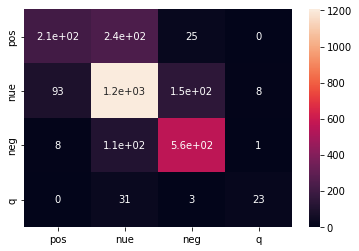

In [ ]:
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True,xticklabels=['pos','nue','neg','q'],yticklabels=['pos','nue','neg','q'])